In [1]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import numpy as np
import nltk

import re
import string
from nltk.corpus import twitter_samples 
from nltk.tag import pos_tag, pos_tag_sents
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk import FreqDist

import torch, random
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import os

random.seed(1)

In [2]:
classifiedSentimentFile = "app_reviews_txt_short0_out.txt"
stop_words_document = "NLTK's list of english stopwords.txt"

train_rate = 0.8
development_rate = 0.1
test_rate = 0.1

k = 2
word_embedding_dim = 200

freeze_if = True

In [3]:
comments = pd.read_csv(classifiedSentimentFile, delimiter='\t', encoding='latin1')
comments.head()

Positive  Negative                                               Text
0         2        -2  Every other (always the first time) I open the...
1         2        -4  Latest update is a huge dissapointment! The ap...
2         1        -2  Recent update has significantly change the app...
3         2        -4  On the latest update using your mobile it is t...
4         3        -3  The standards have really slipped lately. Now ...

In [4]:
label_sentistrength = []
for i,row in comments.iterrows():
    p = row[0]
    n = row[1]
    if p+n == 0:
        label_sentistrength.append(0)
    elif p+n<0:
        label_sentistrength.append(-1)
    elif p+n>0:
        label_sentistrength.append(1)
    if row[2] is np.NaN:
        comments.iloc[i,2] = 'N/A'
comments['label_sentistrength'] = label_sentistrength

print('Total: ',len(label_sentistrength),' Positive: ',np.sum(np.array(label_sentistrength)==1),' Negative: ',np.sum(np.array(label_sentistrength)==-1))

Total:  20000  Positive:  8758  Negative:  5012


In [5]:
"""with open(stop_words_document,"r") as f2:
    stop_word = [] #读取停用词
    for line in f2.readlines():
        line = line.strip('\n')
        stop_word.append(line)
        """

'with open(stop_words_document,"r") as f2:\n    stop_word = [] #读取停用词\n    for line in f2.readlines():\n        line = line.strip(\'\n\')\n        stop_word.append(line)\n        '

In [6]:
"""question_word=["what","which","who","whom","when","where","why","how"]
punc = [',','.','!','?','@','#','$','%','^','*','(',')','~',"'",'"','/',':','\'\'','``']
stop_word = [i for i in stop_word if i not in question_word]
stop_word += punc"""

'question_word=["what","which","who","whom","when","where","why","how"]\npunc = [\',\',\'.\',\'!\',\'?\',\'@\',\'#\',\'$\',\'%\',\'^\',\'*\',\'(\',\')\',\'~\',"\'",\'"\',\'/\',\':\',\'\'\'\',\'``\']\nstop_word = [i for i in stop_word if i not in question_word]\nstop_word += punc'

In [7]:
"""data = np.array(comments).tolist()
print(data[0])"""

'data = np.array(comments).tolist()\nprint(data[0])'

In [8]:
"""data = np.array(comments).tolist()
print(data[0])
data_len = len(comments)
train_len = int(data_len * (1-development_rate-test_rate)) #训练集大小
dev_len = int(data_len * development_rate) #测试集大小
test_len = data_len - train_len - dev_len
    
# split the dataframe
idx = data[:]
random.seed(1)
random.shuffle(idx)  # 将index列表打乱
df_train = data[:train_len] #训练集
df_dev = data[train_len:train_len+dev_len] #测试集
df_test = data[train_len+dev_len:] #测试集  

# 划分label和question
train_label = []
train_content = []
dev_label = []
dev_content = []
test_label = []
test_content = []   

for sent in df_train:
    train_label.append(sent[3])
    train_content.append(sent[2])
for sent in df_dev:
    dev_label.append(sent[3])
    dev_content.append(sent[2])
for sent in df_test:
    test_label.append(sent[3])
    test_content.append(sent[2])
    
data_train_low = [wd.lower() for wd in train_content]
data_dev_low = [wd.lower() for wd in dev_content]
data_test_low = [wd.lower() for wd in test_content]"""

'data = np.array(comments).tolist()\nprint(data[0])\ndata_len = len(comments)\ntrain_len = int(data_len * (1-development_rate-test_rate)) #训练集大小\ndev_len = int(data_len * development_rate) #测试集大小\ntest_len = data_len - train_len - dev_len\n    \n# split the dataframe\nidx = data[:]\nrandom.seed(1)\nrandom.shuffle(idx)  # 将index列表打乱\ndf_train = data[:train_len] #训练集\ndf_dev = data[train_len:train_len+dev_len] #测试集\ndf_test = data[train_len+dev_len:] #测试集  \n\n# 划分label和question\ntrain_label = []\ntrain_content = []\ndev_label = []\ndev_content = []\ntest_label = []\ntest_content = []   \n\nfor sent in df_train:\n    train_label.append(sent[3])\n    train_content.append(sent[2])\nfor sent in df_dev:\n    dev_label.append(sent[3])\n    dev_content.append(sent[2])\nfor sent in df_test:\n    test_label.append(sent[3])\n    test_content.append(sent[2])\n    \ndata_train_low = [wd.lower() for wd in train_content]\ndata_dev_low = [wd.lower() for wd in dev_content]\ndata_test_low = [wd.lower() 

In [9]:
"""word_train = []
word_dev = []
word_test = []  

for sent in data_train_low:
    ss = []
    sent2 = sent.split()
    for wd in sent2:
        if wd not in stop_word:
            ss.append(wd)
        else:
            continue
    word_train.append(ss)
for sent in data_dev_low:
    ss = []
    sent2 = sent.split()
    for wd in sent2:
        if wd not in stop_word:
            ss.append(wd)
        else:
            continue
    word_dev.append(ss)
for sent in data_test_low:
    ss = []
    sent2 = sent.split()
    for wd in sent2:
        if wd not in stop_word:
            ss.append(wd)
        else:
            continue
    word_test.append(ss)
    
words = [] #将训练集中句子分为单词
for line in word_train:
    words += line
        
#统计每个单词出现的次数，放入字典
dic_times = {}
for word in words:
    if word in dic_times:
        dic_times[word] += 1
    else:
        dic_times[word] = 1
            
#删除次数小于k次的单词        
for word in list(dic_times.keys()):
    if dic_times[word] <=k:
        del dic_times[word]
            
#输出字典中的key作为list
words_set = list(dic_times.keys())

words_set_without = [i for i in words_set if i not in stop_word] #删除停用词之后的词集
    
#删除标点符号
words_rand = []
for word in words_set_without:
    if word.isdigit():
        words_rand.append(word)
    elif word.isalpha():
        words_rand.append(word)
    else:
        continue
    
"""

'word_train = []\nword_dev = []\nword_test = []  \n\nfor sent in data_train_low:\n    ss = []\n    sent2 = sent.split()\n    for wd in sent2:\n        if wd not in stop_word:\n            ss.append(wd)\n        else:\n            continue\n    word_train.append(ss)\nfor sent in data_dev_low:\n    ss = []\n    sent2 = sent.split()\n    for wd in sent2:\n        if wd not in stop_word:\n            ss.append(wd)\n        else:\n            continue\n    word_dev.append(ss)\nfor sent in data_test_low:\n    ss = []\n    sent2 = sent.split()\n    for wd in sent2:\n        if wd not in stop_word:\n            ss.append(wd)\n        else:\n            continue\n    word_test.append(ss)\n    \nwords = [] #将训练集中句子分为单词\nfor line in word_train:\n    words += line\n        \n#统计每个单词出现的次数，放入字典\ndic_times = {}\nfor word in words:\n    if word in dic_times:\n        dic_times[word] += 1\n    else:\n        dic_times[word] = 1\n            \n#删除次数小于k次的单词        \nfor word in list(dic_times.keys()):\n 

In [10]:
"""len(words_rand)"""

'len(words_rand)'

In [11]:
"""#加入#UNK#
words_rand.append('#UNK#')
#加入#Padding#
words_rand.append('#Padding#')
    
#随机embedding： word_to_idx为字典
word_to_idx = {word: i for i, word in enumerate(words_rand)}     #把每个单词都编号，因为在embedding中取出词向量时只能用数字
embedding = nn.Embedding(len(words_rand), word_embedding_dim)                     #每个词向量长度为200，即有200个特征
vecs = []
for i in range(len(word_to_idx)):
    word_idx = torch.LongTensor([i])        #假如我想取出单词trust的词向量
    vec = embedding(word_idx)[0]
    vecs.append(vec.tolist())
    
word2vec = word_to_idx
for word in word2vec:
    word2vec[word] = vecs[word_to_idx[word]]
"""

"#加入#UNK#\nwords_rand.append('#UNK#')\n#加入#Padding#\nwords_rand.append('#Padding#')\n    \n#随机embedding： word_to_idx为字典\nword_to_idx = {word: i for i, word in enumerate(words_rand)}     #把每个单词都编号，因为在embedding中取出词向量时只能用数字\nembedding = nn.Embedding(len(words_rand), word_embedding_dim)                     #每个词向量长度为200，即有200个特征\nvecs = []\nfor i in range(len(word_to_idx)):\n    word_idx = torch.LongTensor([i])        #假如我想取出单词trust的词向量\n    vec = embedding(word_idx)[0]\n    vecs.append(vec.tolist())\n    \nword2vec = word_to_idx\nfor word in word2vec:\n    word2vec[word] = vecs[word_to_idx[word]]\n"

In [12]:
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.collocations import BigramCollocationFinder  
from nltk.metrics import BigramAssocMeasures
#nltk.download()
#example = "This is an example sentence! However, it isn't a very informative"
#print(word_tokenize(example, language='english'))

In [13]:
from nltk.tokenize import word_tokenize, RegexpTokenizer
 
example = "This is an example sentence! However, it isn't a very informative one"
 
print(word_tokenize(example, language='english'))

['This', 'is', 'an', 'example', 'sentence', '!', 'However', ',', 'it', 'is', "n't", 'a', 'very', 'informative', 'one']


In [14]:
from nltk.corpus import stopwords
 
stop_words = stopwords.words('english')
print(len(stop_words),stop_words[:20])

179 ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his']


In [15]:
allowed_word_types = ['MD', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'RP', 'RB', 'RBR', 'RBS', 'JJ', 'JJR', 'JJS']
def process_text(content):
    tokens = []
    for line in content:
        #toks = tokenizer.tokenize(line)
        linecleaned = re.sub(r'[^(a-zA-Z)\s]','', line)
        toks = word_tokenize(linecleaned, language='english')
        
        pos = nltk.pos_tag(toks)
        # make a list of  all adjectives identified by the allowed word types list above
        wordsallow = []
        for w,p in pos:
            if p in allowed_word_types:
                wordsallow.append(w)

        toks = [t.lower() for t in wordsallow if t.lower() not in stop_words]
        tokens.extend(toks)
    
    return tokens

def process_text_sent(content):
    tokens = []
    for line in content:
        #toks = tokenizer.tokenize(line)
        linecleaned = re.sub(r'[^(a-zA-Z)\s]','', line)
        toks = word_tokenize(linecleaned, language='english')
        
        pos = nltk.pos_tag(toks)
        # make a list of  all adjectives identified by the allowed word types list above
        wordsallow = []
        for w,p in pos:
            if p in allowed_word_types:
                wordsallow.append(w)

        toks = [t.lower() for t in wordsallow if t.lower() not in stop_words]
        tokens.append(toks)
    
    return tokens

In [16]:
content_all = comments['Text'].tolist()
print(content_all[:5])
words_all = process_text(content_all)
print(len(words_all),words_all[:30])

['Every other (always the first time) I open the app. It won\'t pass the "you can\'t join prime on the app" page, so I always have to reopen it. Also, unless the internet is perfect. It takes forever to load. The filters are too simple and too few. You can\'t choose your own price range, only something like Â£1-Â£25, Â£25-Â£50 (but not both (why?)). Also, changing the order will not work (or I\'m too impatient to wait) unless signal is perfect.', 'Latest update is a huge dissapointment! The app is incredibly slow to load, I haven\'t seen something so slow since Internet Explorer... In the previous version, the account dashboard was so easy to access, now it\'s like going through a maze to access anything... Trying to track your parcel to get an idea when it will be delivered? I think you\'ve got better chances of catching 5G network on a flying plane. This "upgrade" was a total fail...', "Recent update has significantly change the app. When clicking on item an error message at the top 

In [17]:
def bag_of_words(words):  
    return dict([(word, True) for word in words]) 

In [18]:
bow = bag_of_words(words_all)
print(len(bow))
print(bow['always'])

10513
True


In [19]:
def bigram(words, score_fn=BigramAssocMeasures.chi_sq, n=5000):  
    bigram_finder = BigramCollocationFinder.from_words(words) #把文本变成双词搭配的形式  
    bigrams = bigram_finder.nbest(score_fn, n) #使用了卡方统计的方法，选择排名前1000的双词  
    return bag_of_words(bigrams)

In [20]:
def bigram_words(words, score_fn=BigramAssocMeasures.chi_sq, n=5000):  
    bigram_finder = BigramCollocationFinder.from_words(words)  
    bigrams = bigram_finder.nbest(score_fn, n)  
    return bag_of_words(words + bigrams) #所有词和(信息量大的)双词搭配一起作为特征 

In [21]:
bibow = bigram(words_all)
bibowall = bigram_words(words_all)
print(len(bibow),len(bibowall))
print(bibow)

5000 15513
{('aa', 'aaaaa'): True, ('aati', 'impotant'): True, ('abholen', 'htten'): True, ('absoluten', 'drei'): True, ('absurdo', 'prum'): True, ('accuratethe', 'enticed'): True, ('accustomed', 'prehighlighted'): True, ('acess', 'childhood'): True, ('acilen', 'yeni'): True, ('acquiesce', 'adhesion'): True, ('additive', 'makeup'): True, ('adhere', 'settingd'): True, ('admitting', 'deficient'): True, ('advirtised', 'falce'): True, ('aesa', 'tooo'): True, ('aessesesssssssee', 'dsddeedsssssssa'): True, ('ainda', 'cancelar'): True, ('ajiijjjnnniijiiiiiijinjijijinnnnnnnnijjiinnijijnjmnnjjjnniijiinnjnmnjjin', 'nnjnmnjjiii'): True, ('ajungi', 'iar'): True, ('alcuni', 'italiana'): True, ('alles', 'bei'): True, ('amenities', 'uncivilised'): True, ('amounts', 'trashes'): True, ('amusing', 'stretchable'): True, ('anaemic', 'strived'): True, ('andriod', 'misding'): True, ('angepasst', 'bekomme'): True, ('anyhing', 'casenot'): True, ('ao', 'contedo'): True, ('apka', 'fajnie'): True, ('aplicacin', 

In [22]:
bgf = BigramCollocationFinder.from_words(words_all)  
bgs = bgf.ngram_fd
bgs[('ca', "n't")]

0

In [23]:
print(bgs[('ca', "n't")])

0


In [24]:
from nltk.probability import FreqDist, ConditionalFreqDist  
def create_word_scores(words): 
    # posWords = pickle.load(open('D:/code/sentiment_test/pos_review.pkl','r')) 
    # negWords = pickle.load(open('D:/code/sentiment_test/neg_review.pkl','r'))
    word_scores = {}
    for word in words:
        if word in word_scores:
            word_scores[word] += 1
        elif word not in word_scores:
            word_scores[word] = 0
    return word_scores #包括了每个词和这个词的信息量 


In [25]:
def create_word_bigram_scores(words):  
    # posdata = pickle.load(open('D:/code/sentiment_test/pos_review.pkl','r')) 
    # negdata = pickle.load(open('D:/code/sentiment_test/neg_review.pkl','r'))
    bgf = BigramCollocationFinder.from_words(words)  
    bgs = bgf.ngram_fd
    word_scores = {}
    for word in words:
        if word in word_scores:
            word_scores[word] += 1
        elif word not in word_scores:
            word_scores[word] = 0
            
    return word_scores.update(bgs) 


In [26]:
"""biword = {}
for key in bgs:
    biword[key] = bgs[key]
word_scores = create_word_scores(words_all)
print(len(word_scores))
word_scores_bi = word_scores
word_scores_bi.update(bgs)

print(len(word_scores),len(word_scores_bi))"""

'biword = {}\nfor key in bgs:\n    biword[key] = bgs[key]\nword_scores = create_word_scores(words_all)\nprint(len(word_scores))\nword_scores_bi = word_scores\nword_scores_bi.update(bgs)\n\nprint(len(word_scores),len(word_scores_bi))'

In [27]:
def find_best_words(word_scores, number):  
    best_vals = sorted(word_scores.iteritems(), key=lambda w,s:s, reverse=True)[:number] #把词按信息量倒序排序。number是特征的维度，是可以不断调整直至最优的 
    best_words = set([w for w, s in best_vals])  
    return best_words 

In [28]:
word_scores_1 = create_word_scores(words_all)  
word_scores_2 = create_word_bigram_scores(words_all) 


In [29]:
def best_word_features(words,best_words): 
    return dict([(word, True) for word in words if word in best_words]) 

In [30]:
"""
数据是人工已经标注好的文本，有一部分积极的文本，一部分是消极的文本。

文本是已经分词去停用词的商品评论，形式大致如下：[[word11, word12, ... word1n], [word21, word22, ... , word2n], ... , [wordn1, wordn2, ... , wordnn]]

这是一个多维数组，每一维是一条评论，每条评论是已经又该评论的分词组成

pos_review = pickle.load(open('D:/code/sentiment_test/pos_review.pkl','r'))  
neg_review = pickle.load(open('D:/code/sentiment_test/neg_review.pkl','r')) 
"""

"\n数据是人工已经标注好的文本，有一部分积极的文本，一部分是消极的文本。\n\n文本是已经分词去停用词的商品评论，形式大致如下：[[word11, word12, ... word1n], [word21, word22, ... , word2n], ... , [wordn1, wordn2, ... , wordnn]]\n\n这是一个多维数组，每一维是一条评论，每条评论是已经又该评论的分词组成\n\npos_review = pickle.load(open('D:/code/sentiment_test/pos_review.pkl','r'))  \nneg_review = pickle.load(open('D:/code/sentiment_test/neg_review.pkl','r')) \n"

In [31]:
# from random import shuffle  
"""shuffle(pos_review) #把积极文本的排列随机化  
size = int(len(pos_review)/2 - 18)  # 我这里积极文本的数据恰好是消极文本的2倍还多18个，所以为了平衡两者数量才这样做。
pos = pos_review[:size]  
neg = neg_review""" 
print('Total: ',len(label_sentistrength),' Positive: ',np.sum(np.array(label_sentistrength)==1),' Negative: ',np.sum(np.array(label_sentistrength)==-1))

Total:  20000  Positive:  8758  Negative:  5012


In [32]:
size = 5000
pos_review_sent = [comments.iloc[i,2] for i in range(len(comments)) if label_sentistrength[i] == 1][:size]
neg_review_sent = [comments.iloc[i,2] for i in range(len(comments)) if label_sentistrength[i] == -1][:size]
pos_review = process_text_sent(pos_review_sent)
neg_review = process_text_sent(neg_review_sent)
print(len(pos_review),pos_review[:5])
print(len(neg_review),neg_review[:5])


5000 [['going', 'back', 'dated', 'scrolling', 'work', 'properly', 'youve', 'decided', 'continue', 'purchase', 'make', 'sure', 'cant', 'cancel', 'simple', 'even', 'hide', 'also', 'get', 'funny', 'maybe', 'interested'], ['unable', 'change', 'move', 'used', 'able', 'change', 'locked', 'foreseeable', 'future', 'switch', 'used', 'able'], ['used', 'run', 'flawlessly', 'dont', 'know', 'last', 'running', 'absolute', 'app', 'crucial', 'check', 'important', 'cant', 'app', 'says', 'went', 'wrong', 'go', 'works', 'fine'], ['unable', 'pick', 'isnt', 'find', 'contact', 'technical', 'tried', 'use', 'write', 'switched', 'different', 'almost', 'done', 'look', 'returned', 'wiped', 'clean', 'first', 'still', 'registered'], ['unusable', 'galaxy', 'else', 'runs', 'great', 'take', 'complete', 'complete', 'gett', 'oops', 'spend', 'fair', 'remains', 'much', 'longer', 'look', 'elsewhere', 'slow', 'unusable', 'internet', 'fix', 'use', 'main']]
5000 [['huge', 'incredibly', 'slow', 'load', 'havent', 'seen', 'slow

In [33]:
size_train = int(size*train_rate)
size_dev = int(size*development_rate)
size_test = int(size*test_rate)

pos_train = pos_review[:size_train]
pos_dev = pos_review[size_train:size_train+size_dev]
pos_test = pos_review[size_train+size_dev:]

neg_train = neg_review[:size_train]
neg_dev = neg_review[size_train:size_train+size_dev]
neg_test = neg_review[size_train+size_dev:]

print(len(pos_train),len(pos_dev),len(pos_test))
print(len(neg_train),len(neg_dev),len(neg_test))

4000 500 500
4000 500 500


In [34]:
def generate_words(sents):
    words = []
    for line in sents:
        words.extend(line)
    return words

pos_train_words = generate_words(pos_train)
pos_dev_words = generate_words(pos_dev)
pos_test_words = generate_words(pos_test)

neg_train_words = generate_words(neg_train)
neg_dev_words = generate_words(neg_dev)
neg_test_words = generate_words(neg_test)

In [35]:
# feature_extraction_method = bag_of_words / bigram / bigram_words  // create_word_bigram_scores / create_word_scores


def pos_features(pos_text, feature_extraction_method):  
    posFeatures = []  
    pos_dict = create_word_scores(pos_text)
    pos_fea = find_best_words(pos_dict,5000)
    best_word_features(pos_text,pos_fea)
    
    posFeatures.append(posWords)  
    return posFeatures 

def neg_features(neg_text, feature_extraction_method):  
    negFeatures = []
    
    negFeatures.append(negWords)  
    return negFeatures 

In [36]:
#train = posFeatures[174:]+negFeatures[174:]  
#devtest = posFeatures[124:174]+negFeatures[124:174]  
#test = posFeatures[:124]+negFeatures[:124] 

In [37]:
def score(classifier):  
    classifier = SklearnClassifier(classifier) #在nltk 中使用scikit-learn 的接口  
    classifier.train(train) #训练分类器  
    pred = classifier.batch_classify(testSet) #对开发测试集的数据进行分类，给出预测的标签  
    return accuracy_score(tag_test, pred) #对比分类预测结果和人工标注的正确结果，给出分类器准确度 

In [38]:
#import sklearn  
  
#print( 'NuSVC`s accuracy is %f' %score(NuSVC()) 
      
"""
BernoulliNB`s accuracy is 0.790000  
MultinomiaNB`s accuracy is 0.810000  
LogisticRegression`s accuracy is 0.710000  
SVC`s accuracy is 0.650000  
LinearSVC`s accuracy is 0.680000  
NuSVC`s accuracy is 0.740000 
"""

'\nBernoulliNB`s accuracy is 0.790000  \nMultinomiaNB`s accuracy is 0.810000  \nLogisticRegression`s accuracy is 0.710000  \nSVC`s accuracy is 0.650000  \nLinearSVC`s accuracy is 0.680000  \nNuSVC`s accuracy is 0.740000 \n'

In [39]:
#posFeatures = pos_features(bigrams)  
#negFeatures = neg_features(bigrams) 

"""
BernoulliNB`s accuracy is 0.710000 
MultinomiaNB`s accuracy is 0.750000 
LogisticRegression`s accuracy is 0.790000 
SVC`s accuracy is 0.750000 
LinearSVC`s accuracy is 0.770000 
NuSVC`s accuracy is 0.780000 

"""

'\nBernoulliNB`s accuracy is 0.710000 \nMultinomiaNB`s accuracy is 0.750000 \nLogisticRegression`s accuracy is 0.790000 \nSVC`s accuracy is 0.750000 \nLinearSVC`s accuracy is 0.770000 \nNuSVC`s accuracy is 0.780000 \n\n'

In [40]:
#posFeatures = pos_features(bigram_words) 
#negFeatures = neg_features(bigram_words)

In [41]:
BOW = nltk.FreqDist(words_all)
#BOW
BOWdict = {}
for key in BOW:
    BOWdict[key] = BOW[key]
BOWdict

{'good': 3602,
 'use': 2985,
 'get': 2891,
 'would': 2306,
 'great': 2038,
 'also': 1944,
 'dont': 1929,
 'even': 1908,
 'cant': 1869,
 'really': 1662,
 'new': 1439,
 'still': 1392,
 'easy': 1382,
 'app': 1377,
 'back': 1377,
 'love': 1291,
 'see': 1281,
 'using': 1186,
 'go': 1173,
 'make': 1161,
 'want': 1123,
 'could': 1109,
 'used': 1091,
 'much': 1081,
 'many': 1063,
 'able': 1041,
 'need': 1031,
 'doesnt': 1014,
 'find': 989,
 'works': 950,
 'well': 944,
 'always': 932,
 'add': 910,
 'never': 892,
 'better': 848,
 'tried': 836,
 'got': 787,
 'fix': 775,
 'know': 754,
 'sometimes': 752,
 'open': 724,
 'try': 718,
 'annoying': 715,
 'working': 702,
 'work': 692,
 'like': 691,
 'first': 680,
 'update': 676,
 'last': 668,
 'however': 651,
 'trying': 650,
 'keep': 647,
 'give': 639,
 'available': 635,
 'getting': 627,
 'think': 614,
 'wont': 585,
 'watch': 575,
 'send': 568,
 'old': 567,
 'bad': 567,
 'going': 564,
 'fine': 536,
 'pay': 534,
 'take': 526,
 'best': 517,
 'long': 516,
 

In [42]:
print(BOW['every'])
word_featureset = sorted(BOWdict.items(), key=lambda s:s[1], reverse=True)[:200]
#sorted(word_scores.iteritems(), key=lambda w,s:s, reverse=True)[:5000] list(BOW.keys())[:5000]
#print(word_features[1:20])
word_features = [s[0] for s in word_featureset]
print(word_features[:20])
print(len(BOWdict))

15
['good', 'use', 'get', 'would', 'great', 'also', 'dont', 'even', 'cant', 'really', 'new', 'still', 'easy', 'app', 'back', 'love', 'see', 'using', 'go', 'make']
10513


In [43]:
pre_trained_document = "glove.small.txt"

def embedding_pre(pre_trained_document,ifFreeze):
    with open(pre_trained_document,"r") as f3:
        glove = [] #读取出的glove
        for line in f3.readlines():
            line = line.strip('\n').split()
            glove.append(line)

    #分离glove为weight和label        
    for i in range(len(glove)):
        for j in range(len(glove[0])-1):
            glove[i][j+1] = float(glove[i][j+1])
    glove_weight = [i[1:] for i in glove]
    glove_label = [i[0] for i in glove]

    #加入#Padding#
    glove_label.append('#Padding#')
    arr_weight = np.array(glove_weight)
    glove_weight.append(list(arr_weight.mean(axis=0)))
    #print(glove_label)
    #print(len(glove_weight[-1]),glove_weight[-1])
    
    #词转序号
    word_to_idx_pre = {word: i for i, word in enumerate(glove_label)}
    weight = torch.Tensor(glove_weight)
    embeddingPre = nn.Embedding.from_pretrained(weight,freeze = ifFreeze)
    
    vecs = []
    for i in range(len(word_to_idx_pre)):
        word_idx = torch.LongTensor([i])        #假如我想取出单词trust的词向量
        vec = embeddingPre(word_idx)[0]
        vecs.append(vec.tolist())
    
    word2vec_pre = {}
    for word in word_to_idx_pre.keys():
        word2vec_pre[word] = vecs[word_to_idx_pre[word]]  
    return word2vec_pre, word_to_idx_pre


In [44]:
word2vec,word2idx = embedding_pre(pre_trained_document,False)
print(len(word2vec))
print(word2vec['good'])
print(word2idx['good'])

9550
[-0.42625001072883606, 0.4431000053882599, -0.3451699912548065, -0.13259999454021454, -0.058159999549388885, 0.052597999572753906, 0.21574999392032623, -0.3672100007534027, -0.0451899990439415, 2.2444000244140625, -0.29089000821113586, 0.16670000553131104, -0.05205100029706955, 0.15963999927043915, -0.427590012550354, -0.11146999895572662, -0.149509996175766, 1.1799999475479126, -0.19603000581264496, 0.15591999888420105, -0.06111999973654747, -0.011575999669730663, 0.2684899866580963, -0.3017500042915344, -0.055796001106500626, 0.12116000056266785, 0.010541999712586403, -0.180649995803833, 0.23281000554561615, -0.2636699974536896, 0.11032000184059143, 0.06216000020503998, 0.015018999576568604, -0.10687000304460526, 0.09848599880933762, 0.04845700040459633, 0.33355000615119934, -0.16177000105381012, -0.2850300073623657, -0.28654998540878296, -0.1124500036239624, 0.12416999787092209, -0.24975000321865082, -0.20080000162124634, 0.26034000515937805, 0.2520799934864044, -0.178409993648

In [45]:
print(len(word2vec['good']))
def embedding_self(pre,features):
    emb_self = {}
    for word in features:
        if word in pre.keys():
            emb_self[word] = pre[word]
    
    return emb_self

word2vec_self = embedding_self(word2vec,word_features)
print(word2vec_self['good'])

300
[-0.42625001072883606, 0.4431000053882599, -0.3451699912548065, -0.13259999454021454, -0.058159999549388885, 0.052597999572753906, 0.21574999392032623, -0.3672100007534027, -0.0451899990439415, 2.2444000244140625, -0.29089000821113586, 0.16670000553131104, -0.05205100029706955, 0.15963999927043915, -0.427590012550354, -0.11146999895572662, -0.149509996175766, 1.1799999475479126, -0.19603000581264496, 0.15591999888420105, -0.06111999973654747, -0.011575999669730663, 0.2684899866580963, -0.3017500042915344, -0.055796001106500626, 0.12116000056266785, 0.010541999712586403, -0.180649995803833, 0.23281000554561615, -0.2636699974536896, 0.11032000184059143, 0.06216000020503998, 0.015018999576568604, -0.10687000304460526, 0.09848599880933762, 0.04845700040459633, 0.33355000615119934, -0.16177000105381012, -0.2850300073623657, -0.28654998540878296, -0.1124500036239624, 0.12416999787092209, -0.24975000321865082, -0.20080000162124634, 0.26034000515937805, 0.2520799934864044, -0.1784099936485

In [46]:
def sent2vec(sentences,emb):
    vecs = []
    for i in range(len(sentences)):
        vec = [0]*300
        words = []
        n = len(sentences[i])
        for j in range(n):
            if sentences[i][j] in emb.keys():
                words.append(emb[sentences[i][j]])
        for i in range(300):   
            temp = 0
            for j in range(len(words)):
                temp += words[j][i]
            if n!=0:
                vec[i]=temp/n
            else:
                vec[i]=0
        vecs.append(vec)
            
    return vecs 
vecs_emb_postrain = sent2vec(pos_train,word2vec_self)
vecs_emb_negtrain = sent2vec(neg_train,word2vec_self)
vecs_emb_posdev = sent2vec(pos_dev,word2vec_self)
vecs_emb_negdev = sent2vec(neg_dev,word2vec_self)
print(vecs_emb_postrain[:5])

[[-0.047848696873932735, 0.0775724094022404, -0.16003045439720154, 0.0027626903664151378, 0.04048754579641602, 0.007063954391262748, -0.024709623645652424, -0.08151027297770436, 0.02909904591400515, 1.1006682027469983, -0.05485022719949484, 0.033392782153731045, 0.0574875132561746, 0.02821727300232107, -0.08882431588558988, -0.05196225920438089, -0.060531863096085464, 0.5350549979643389, -0.12033241276036609, 0.011311726983297955, -0.0019488122779875994, 0.006071704778481613, 0.005056354010858658, -0.04617690972306512, -0.042413045736876404, -0.003807727416807955, 0.020988909188996662, -0.15032636374235153, 0.06585545499216426, -0.15632936426184393, -0.06279103089631959, -0.0014846915675496514, -0.012444864111867819, -0.012173182055862113, 0.034756185063584286, -0.03573877203532241, 0.04797004611993378, 0.06297213685783473, 0.011069091121581469, -0.059037369125607336, -0.04217713631012223, 0.05296572738073089, 0.011430858401581645, -0.0805503659966317, 0.0006970907561480999, 0.09152822

In [47]:
trainingset_pre = []
trainingset_label_pre = []
for i in range(len(vecs_emb_postrain)):
    trainingset_pre.append((vecs_emb_postrain[i],'1'))
    #trainingset_label_pre.append('1')
for i in range(len(vecs_emb_negtrain)):
    trainingset_pre.append((vecs_emb_negtrain[i],'0'))
    #trainingset_label_pre.append('-1')
print(len(trainingset_pre))
print(trainingset_pre[1])
random.seed(1)
random.shuffle(trainingset_pre) 

for i in range(len(trainingset_pre)):
    trainingset_label_pre.append(trainingset_pre[i][1])
    trainingset_pre[i] = trainingset_pre[i][0]
    
print(trainingset_pre[1])

devset_pre = []
devset_label_pre = []
for i in range(len(vecs_emb_posdev)):
    devset_pre.append(vecs_emb_postrain[i])
    devset_label_pre.append('1')
for i in range(len(vecs_emb_negdev)):
    devset_pre.append(vecs_emb_negtrain[i])
    devset_label_pre.append('0')
print(devset_pre[1])

8000
([-0.0011566653847694397, 0.10094666729370753, -0.04639833296338717, -0.04141333202521006, -0.09602666894594829, 0.08126000066598256, -0.06935899890959263, 0.03974950065215429, -0.07542499899864197, 0.6435666680335999, -0.11321577965281904, 0.0861833319067955, 0.06618016523619492, -0.04644333322842916, -0.000126667320728302, -0.0013988334685564041, -0.04419171460904181, 0.5458499987920126, -0.1047516663869222, -0.08797333637873332, -0.014950833593805632, -0.033440667359779276, -0.0736333355307579, 0.01028833289941152, -0.01399750014146169, 0.015211500227451324, -0.08781666805346806, -0.09138999879360199, -0.019651833300789196, 0.023128333191076916, -0.01570628327317536, 0.05413400133450826, 0.05267833173274994, -0.020313334961732227, 0.10883583625157674, -0.03494850049416224, 0.09533499926328659, -0.005963999778032303, -0.04975766564408938, -0.06955166906118393, -0.024881499043355387, 0.027497832973798115, 0.02252300052593152, 0.04732466675341129, -0.024369999766349792, -0.0167508

In [48]:
from sklearn.neural_network import MLPClassifier
from datetime import datetime
from sklearn.metrics import classification_report

clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1,max_iter=5000)
current_time = datetime.now()
clf.fit(trainingset_pre, trainingset_label_pre)
print("the training time of MLP classifier:", datetime.now()-current_time)

print("the Accuracy of training set for MLP classifier:",clf.score(trainingset_pre,trainingset_label_pre))
print("the Accuracy of testing set for MLP classifier:",clf.score(devset_pre,devset_label_pre))
devset_label_predict = clf.predict(devset_pre)
print(classification_report(devset_label_pre, devset_label_predict, target_names=['Negative','Positive']))

the training time of MLP classifier: 0:00:16.512092
the Accuracy of training set for MLP classifier: 0.77475
the Accuracy of testing set for MLP classifier: 0.744
              precision    recall  f1-score   support

    Negative       0.71      0.82      0.76       500
    Positive       0.79      0.67      0.72       500

    accuracy                           0.74      1000
   macro avg       0.75      0.74      0.74      1000
weighted avg       0.75      0.74      0.74      1000



In [49]:
clf2 = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(20, 2), random_state=1,max_iter=30000,max_fun=30000)
current_time2 = datetime.now()
clf2.fit(trainingset_pre, trainingset_label_pre)
print("the training time of MLP classifier:", datetime.now()-current_time2)

print("the Accuracy of training set for MLP classifier:",clf2.score(trainingset_pre,trainingset_label_pre))
print("the Accuracy of testing set for MLP classifier:",clf2.score(devset_pre,devset_label_pre))

the training time of MLP classifier: 0:03:13.292626
the Accuracy of training set for MLP classifier: 0.941625
the Accuracy of testing set for MLP classifier: 0.951


In [73]:
clf3 = MLPClassifier(solver='adam', alpha=1e-5,hidden_layer_sizes=(300, 2), random_state=1,max_iter=30000)
current_time2 = datetime.now()
clf3.fit(trainingset_pre, trainingset_label_pre)
print("the training time of MLP classifier:", datetime.now()-current_time2)

print("the Accuracy of training set for MLP classifier:",clf3.score(trainingset_pre,trainingset_label_pre))
print("the Accuracy of testing set for MLP classifier:",clf3.score(devset_pre,devset_label_pre))

the training time of MLP classifier: 0:00:24.721945
the Accuracy of training set for MLP classifier: 0.943625
the Accuracy of testing set for MLP classifier: 0.953


In [75]:
devset_label_predict = clf3.predict(devset_pre)
print(classification_report(devset_label_pre, devset_label_predict, target_names=['Negative','Positive']))

              precision    recall  f1-score   support

    Negative       0.99      0.92      0.95       500
    Positive       0.92      0.99      0.95       500

    accuracy                           0.95      1000
   macro avg       0.96      0.95      0.95      1000
weighted avg       0.96      0.95      0.95      1000



In [51]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [52]:
#content_all = comments['Text'].tolist()
def find_features(document,word_features):
    #words = word_tokenize(document)
    features = {}
    for w in word_features:
        features[w] = (w in document)

    return features

posfeatures = [(find_features(line,word_features), '1') for line in pos_train]
print('pos finish')
negfeatures = [(find_features(line,word_features), '0') for line in neg_train] 
print('feature train finish')

posfeatures_dev = [(find_features(line,word_features), '1') for line in pos_dev]
print('pos finish')
negfeatures_dev = [(find_features(line,word_features), '0') for line in neg_dev]
#print(posfeatures[:2])

pos finish
feature train finish
pos finish


In [53]:
print(posfeatures[:5])
print(pos_train[:500])

[({'good': False, 'use': False, 'get': True, 'would': False, 'great': False, 'also': True, 'dont': False, 'even': True, 'cant': True, 'really': False, 'new': False, 'still': False, 'easy': False, 'app': False, 'back': True, 'love': False, 'see': False, 'using': False, 'go': False, 'make': True, 'want': False, 'could': False, 'used': False, 'much': False, 'many': False, 'able': False, 'need': False, 'doesnt': False, 'find': False, 'works': False, 'well': False, 'always': False, 'add': False, 'never': False, 'better': False, 'tried': False, 'got': False, 'fix': False, 'know': False, 'sometimes': False, 'open': False, 'try': False, 'annoying': False, 'working': False, 'work': True, 'like': False, 'first': False, 'update': False, 'last': False, 'however': False, 'trying': False, 'keep': False, 'give': False, 'available': False, 'getting': False, 'think': False, 'wont': False, 'watch': False, 'send': False, 'old': False, 'bad': False, 'going': True, 'fine': False, 'pay': False, 'take': Fals

In [54]:
allset = posfeatures + negfeatures
# Shuffling the documents 
random.shuffle(allset)
print([f[1] for f in allset])
 
training_set = allset
testing_set = posfeatures_dev + negfeatures_dev
random.shuffle(testing_set)
print(len(allset),len(training_set),len(testing_set))
print()
#print(testing_set[:20])

['1', '0', '0', '1', '1', '0', '0', '1', '1', '0', '0', '1', '1', '0', '0', '0', '1', '1', '0', '1', '0', '0', '1', '0', '1', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '1', '0', '1', '1', '0', '1', '1', '1', '0', '1', '1', '0', '0', '1', '1', '0', '1', '1', '1', '1', '0', '1', '1', '1', '1', '0', '0', '1', '1', '0', '0', '1', '1', '1', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1', '1', '1', '1', '1', '1', '0', '0', '1', '1', '0', '1', '1', '1', '0', '1', '0', '0', '0', '0', '1', '0', '0', '1', '0', '0', '1', '0', '1', '1', '1', '1', '1', '0', '0', '1', '1', '1', '1', '0', '1', '0', '1', '0', '0', '1', '0', '0', '1', '1', '1', '1', '1', '0', '0', '1', '0', '0', '0', '1', '1', '1', '0', '1', '0', '1', '1', '0', '0', '0', '1', '0', '0', '1', '0', '0', '1', '0', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '0', '1', '0', '0', '1', '0', '0', '1', '1', '1', '0', '0', '1', '0', '0', '0', '1', '0', '1', '0', '0', '0', '1', '0', '0', '0', '1', '1',

In [55]:
lt = len(testing_set)
numpos = 0
numneg = 0
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!应该不加label吧

for i in range(lt):
    if testing_set[i][1] == '0':
        numneg +=1
    elif testing_set[i][1] == '1':
        numpos +=1
print(lt,numpos,numneg)

1000 500 500


In [56]:
from datetime import datetime
from sklearn.metrics import classification_report
current_time_NB = datetime.now()

classifier = nltk.NaiveBayesClassifier.train(training_set)
print("the training time of Naive Bayes classifier:", datetime.now()-current_time_NB)
print("training set accuracy percent:",(nltk.classify.accuracy(classifier, training_set))*100)
print("Classifier accuracy percent:",(nltk.classify.accuracy(classifier, testing_set))*100)
y_true = [int(label[1]) for label in testing_set ]
y_pred = classifier.classify_many([label[0] for label in testing_set ])
y_pred = [int(l) for l in y_pred]
print(classification_report(y_true, y_pred, target_names=['Negative','Positive']))
classifier.show_most_informative_features(15)


the training time of Naive Bayes classifier: 0:00:01.525092
training set accuracy percent: 75.925
Classifier accuracy percent: 62.0
              precision    recall  f1-score   support

    Negative       0.61      0.65      0.63       500
    Positive       0.63      0.59      0.61       500

    accuracy                           0.62      1000
   macro avg       0.62      0.62      0.62      1000
weighted avg       0.62      0.62      0.62      1000

Most Informative Features
                terrible = True                0 : 1      =     73.4 : 1.0
             frustrating = True                0 : 1      =     43.0 : 1.0
                 useless = True                0 : 1      =     40.1 : 1.0
                annoying = True                0 : 1      =     20.6 : 1.0
                    scan = True                0 : 1      =      7.5 : 1.0
                 amazing = True                1 : 0      =      6.3 : 1.0
                    love = True                1 : 0      =      

In [57]:
from nltk.classify.scikitlearn import SklearnClassifier
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.svm import SVC

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

In [58]:
def classifier_self(classifier,name,trainset,testset):
    current_time = datetime.now()
    classifier.train(trainset)
    print("the training time of", name,"classifier:", datetime.now()-current_time)
    print("the Accuracy of training set for",name,":",(nltk.classify.accuracy(classifier, training_set))*100)
    print("the Accuracy of testing set for",name,":",(nltk.classify.accuracy(classifier, testing_set))*100)
    y_true = [int(label[1]) for label in testing_set ]
    y_pred = classifier.classify_many([label[0] for label in testing_set ])
    y_pred = [int(l) for l in y_pred]
    print(classification_report(y_true, y_pred, target_names=['Negative','Positive']))
    #classifier.show_most_informative_features(15)

In [70]:
#NB_clf = nltk.NaiveBayesClassifier()
#classifier_self(NB_clf,"Naive Bayes",training_set,testing_set)
random.seed(1)

MNB_clf = SklearnClassifier(MultinomialNB())
classifier_self(MNB_clf,"Multinomial Naive Bayes",training_set,testing_set)

LogReg_clf = SklearnClassifier(LogisticRegression())
classifier_self(LogReg_clf,"Logistic Regression",training_set,testing_set)

SVC_clf = SklearnClassifier(SVC())
classifier_self(SVC_clf,"Support Vector Machine",training_set,testing_set)

DTC_clf = SklearnClassifier(DecisionTreeClassifier())
classifier_self(DTC_clf,"Decision Tree",training_set,testing_set)

RFC_clf = SklearnClassifier(RandomForestClassifier(random_state=0))
classifier_self(RFC_clf,"Random Forest",training_set,testing_set)

the training time of Multinomial Naive Bayes classifier: 0:00:01.231811
the Accuracy of training set for Multinomial Naive Bayes : 76.7375
the Accuracy of testing set for Multinomial Naive Bayes : 66.2
              precision    recall  f1-score   support

    Negative       0.62      0.81      0.71       500
    Positive       0.73      0.51      0.60       500

    accuracy                           0.66      1000
   macro avg       0.68      0.66      0.65      1000
weighted avg       0.68      0.66      0.65      1000

the training time of Logistic Regression classifier: 0:00:01.452185
the Accuracy of training set for Logistic Regression : 80.7
the Accuracy of testing set for Logistic Regression : 66.0
              precision    recall  f1-score   support

    Negative       0.64      0.73      0.68       500
    Positive       0.68      0.59      0.64       500

    accuracy                           0.66      1000
   macro avg       0.66      0.66      0.66      1000
weighted avg

In [60]:
print("Original Naive Bayes Algo accuracy percent:", (nltk.classify.accuracy(classifier, testing_set))*100)
classifier.show_most_informative_features(15)

MNB_clf = SklearnClassifier(MultinomialNB())
current_time = datetime.now()
MNB_clf.train(training_set)
print("the training time of Multinomial Naive Bayes classifier:", datetime.now()-current_time_NB)
print("MNB_classifier accuracy percent:", (nltk.classify.accuracy(MNB_clf, training_set))*100)
print("MNB_classifier accuracy percent:", (nltk.classify.accuracy(MNB_clf, testing_set))*100)

BNB_clf = SklearnClassifier(BernoulliNB())
current_time = datetime.now()
BNB_clf.train(training_set)
print("the training time of Bernoulli Naive Bayes classifier:", datetime.now()-current_time_NB)
print("BernoulliNB_classifier accuracy percent:", (nltk.classify.accuracy(BNB_clf, training_set))*100)
print("BernoulliNB_classifier accuracy percent:", (nltk.classify.accuracy(BNB_clf, testing_set))*100)

LogReg_clf = SklearnClassifier(LogisticRegression())
current_time = datetime.now()
LogReg_clf.train(training_set)
print("the training time of Logistic Regression classifier:", datetime.now()-current_time_NB)
print("LogisticRegression_classifier accuracy percent:", (nltk.classify.accuracy(LogReg_clf, training_set))*100)
print("LogisticRegression_classifier accuracy percent:", (nltk.classify.accuracy(LogReg_clf, testing_set))*100)

SGD_clf = SklearnClassifier(SGDClassifier())
current_time = datetime.now()
SGD_clf.train(training_set)
print("the training time of SGD classifier:", datetime.now()-current_time_NB)
print("SGDClassifier_classifier accuracy percent:", (nltk.classify.accuracy(SGD_clf, training_set))*100)
print("SGDClassifier_classifier accuracy percent:", (nltk.classify.accuracy(SGD_clf, testing_set))*100)

SVC_clf = SklearnClassifier(SVC())
current_time = datetime.now()
SVC_clf.train(training_set)
print("the training time of Support Vector Machine classifier:", datetime.now()-current_time_NB)
print("SVC_classifier accuracy percent:", (nltk.classify.accuracy(SVC_clf, training_set))*100)
print("SVC_classifier accuracy percent:", (nltk.classify.accuracy(SVC_clf, testing_set))*100)

Original Naive Bayes Algo accuracy percent: 62.0
Most Informative Features
                terrible = True                0 : 1      =     73.4 : 1.0
             frustrating = True                0 : 1      =     43.0 : 1.0
                 useless = True                0 : 1      =     40.1 : 1.0
                annoying = True                0 : 1      =     20.6 : 1.0
                    scan = True                0 : 1      =      7.5 : 1.0
                 amazing = True                1 : 0      =      6.3 : 1.0
                    love = True                1 : 0      =      6.2 : 1.0
                    poor = True                0 : 1      =      5.3 : 1.0
                   great = True                1 : 0      =      5.0 : 1.0
                    nice = True                1 : 0      =      4.1 : 1.0
                     bad = True                0 : 1      =      4.0 : 1.0
               difficult = True                0 : 1      =      3.8 : 1.0
                    goes 

In [61]:


DTC_clf = SklearnClassifier(DecisionTreeClassifier())
DTC_clf.train(training_set)
print("DTCClassifier_classifier accuracy percent:", (nltk.classify.accuracy(DTC_clf, training_set))*100)
print("DTCClassifier_classifier accuracy percent:", (nltk.classify.accuracy(DTC_clf, testing_set))*100)

DTCClassifier_classifier accuracy percent: 95.8
DTCClassifier_classifier accuracy percent: 62.5


In [62]:
RFC_clf = SklearnClassifier(RandomForestClassifier())
RFC_clf.train(training_set)
print("RFCClassifier_classifier accuracy percent:", (nltk.classify.accuracy(RFC_clf, training_set))*100)
print("RFCClassifier_classifier accuracy percent:", (nltk.classify.accuracy(RFC_clf, testing_set))*100)

RFCClassifier_classifier accuracy percent: 95.8
RFCClassifier_classifier accuracy percent: 66.5


In [63]:
MEC_clf = nltk.MaxentClassifier
MEC_clf.train(training_set,algorithm = 'GIS',max_iter=3)
#print("MENClassifier_classifier accuracy percent:",MEC_clf.classify(testing_set))

  ==> Training (3 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.500
             2          -0.68896        0.759
         Final          -0.68483        0.755


<ConditionalExponentialClassifier: 2 labels, 800 features>

In [64]:
testing_set

[({'good': False,
   'use': False,
   'get': False,
   'would': False,
   'great': False,
   'also': False,
   'dont': False,
   'even': False,
   'cant': False,
   'really': False,
   'new': True,
   'still': False,
   'easy': False,
   'app': False,
   'back': False,
   'love': False,
   'see': False,
   'using': False,
   'go': False,
   'make': False,
   'want': False,
   'could': False,
   'used': False,
   'much': False,
   'many': False,
   'able': False,
   'need': False,
   'doesnt': False,
   'find': False,
   'works': False,
   'well': False,
   'always': False,
   'add': False,
   'never': False,
   'better': False,
   'tried': False,
   'got': False,
   'fix': False,
   'know': False,
   'sometimes': False,
   'open': False,
   'try': False,
   'annoying': False,
   'working': False,
   'work': False,
   'like': False,
   'first': False,
   'update': False,
   'last': False,
   'however': False,
   'trying': False,
   'keep': False,
   'give': False,
   'available': False,

In [65]:
nltk.classify.accuracy(MEC_clf, training_set)

TypeError: classify_many() missing 1 required positional argument: 'featuresets'

In [ ]:


#nltk.classify.accuracy(MEC_clf, testing_set)
for featureset in testing_set:
    pdist = classifier.prob_classify(featureset)
    print('%8.2f%6.2f' % (pdist.prob('x'), pdist.prob('y')), end=' ')

[-0.2  0.8  1.8  2.8  3.8  4.8]


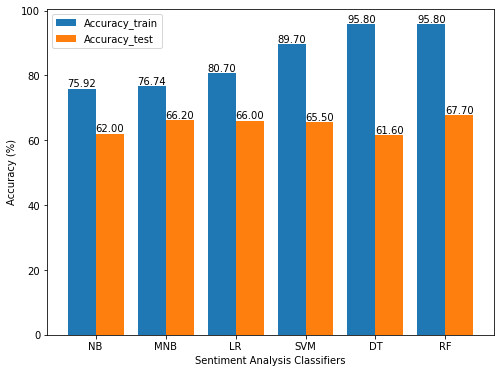

In [128]:
import matplotlib.pyplot as plt
import numpy as np

size = 6
# 返回size个0-1的随机数
accuracy_train = [75.925,76.7375,80.7,89.7,95.8,95.8]
accuracy_test = [62.0,66.2,66.0,65.5,61.6,67.7]
#F1 = np.random.random(size)
# x轴坐标, size=5, 返回[0, 1, 2, 3, 4]
x = np.arange(size)

# 有a/b/c三种类型的数据，n设置为3
total_width, n = 0.8, 2
# 每种类型的柱状图宽度
width = total_width / n

# 重新设置x轴的坐标
x = x - (total_width - width) / 2
print(x)
scale = 8
ratio = 0.75
plt.figure(figsize=(scale, scale*ratio))
# 画柱状图
plt.bar(x - width/2, accuracy_train, width=width, label="Accuracy_train")
plt.bar(x + width/2, accuracy_test, width=width, label="Accuracy_test")
#plt.bar(x + 2*width, c, width=width, label="c")

# 功能1
x_label = ["Naive Bayes", "Multinomial Naive Bayes", "Logistic Regression", "Support Vector Machine", "Decision Tree","Random Forest"]
x_labels = ["NB", "MNB", "LR", "SVM", "DT","RF"]
# 用第1组...替换横坐标x的值
plt.xticks(x, x_labels)

# 功能2
fsize = 10
for i, j in zip(x - width/2, accuracy_train):
    plt.text(i, j + 0.01, "%.2f" % j, ha="center", va="bottom", fontsize=fsize)
for i, j in zip(x + width/2, accuracy_test):
    plt.text(i, j + 0.01, "%.2f" % j, ha="center", va="bottom", fontsize=fsize)
#for i, j in zip(x + 2 * width, c):
#    plt.text(i, j + 0.01, "%.2f" % j, ha="center", va="bottom", fontsize=7)

# 设置x轴标签名
plt.xlabel("Sentiment Analysis Classifiers")
# 设置y轴标签名
plt.ylabel("Accuracy (%)")    
# 显示图例
plt.legend()
# 显示柱状图
plt.show()


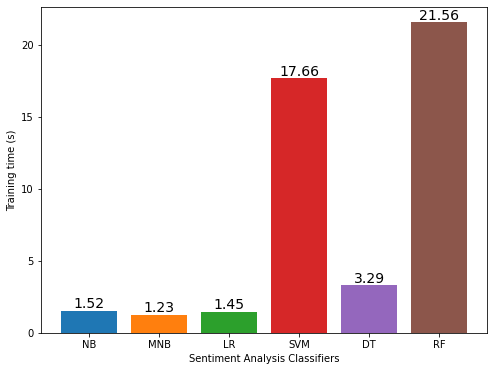

In [120]:
# 准备数据
x_data =  ["NB", "MNB", "LR", "SVM", "DT","RF"]
y_data = [1.52,1.23,1.45,17.66,3.29,21.56]
plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False

scale = 8
ratio = 0.75
plt.figure(figsize=(scale, scale*ratio))



size = 6
x = np.arange(size)


# 画图，plt.bar()可以画柱状图
for i in range(len(x_data)):
    plt.bar(x_data[i], y_data[i])
    
fsize = 14
for i, j in zip(x, y_data):
    plt.text(i, j + 0.01, "%.2f" % j, ha="center", va="bottom", fontsize=fsize)
    
# 设置x轴标签名
plt.xlabel("Sentiment Analysis Classifiers")
# 设置y轴标签名
plt.ylabel("Training time (s)")
# 显示
plt.show()


[0 1 2]


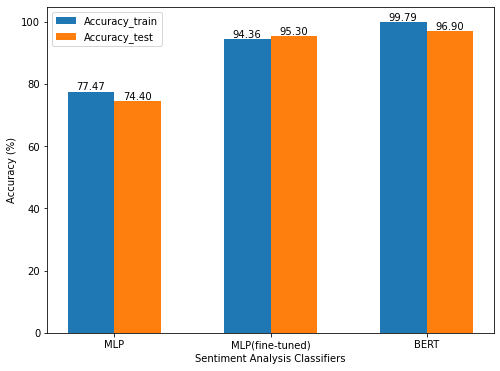

In [129]:
size = 3
# 返回size个0-1的随机数
accuracy_train = [77.475,94.3625,99.788]
accuracy_test = [74.4,95.3,96.897]
#F1 = np.random.random(size)
# x轴坐标, size=5, 返回[0, 1, 2, 3, 4]
x = np.arange(size)

# 有a/b/c三种类型的数据，n设置为3
total_width, n = 0.6, 2
# 每种类型的柱状图宽度
width = total_width / n

# 重新设置x轴的坐标
#x = x - (total_width - width) / 2
print(x)
scale = 8
ratio = 0.75
plt.figure(figsize=(scale, scale*ratio))
# 画柱状图
plt.bar(x - width/2, accuracy_train, width=width, label="Accuracy_train")
plt.bar(x + width/2, accuracy_test, width=width, label="Accuracy_test")
#plt.bar(x + 2*width, c, width=width, label="c")

# 功能1
x_labels = ["MLP", "MLP(fine-tuned)", "BERT"]
# 用第1组...替换横坐标x的值
plt.xticks(x, x_labels)

# 功能2
fsize = 10
for i, j in zip(x - width/2, accuracy_train):
    plt.text(i, j + 0.01, "%.2f" % j, ha="center", va="bottom", fontsize=fsize)
for i, j in zip(x + width/2, accuracy_test):
    plt.text(i, j + 0.01, "%.2f" % j, ha="center", va="bottom", fontsize=fsize)
#for i, j in zip(x + 2 * width, c):
#    plt.text(i, j + 0.01, "%.2f" % j, ha="center", va="bottom", fontsize=7)

# 设置x轴标签名
plt.xlabel("Sentiment Analysis Classifiers")
# 设置y轴标签名
plt.ylabel("Accuracy (%)")    
# 显示图例
plt.legend()
# 显示柱状图
plt.show()

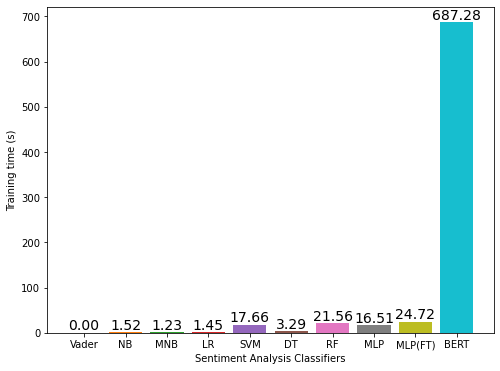

In [136]:
x_data =  ["Vader","NB", "MNB", "LR", "SVM", "DT","RF","MLP","MLP(FT)","BERT"]
y_data = [0,1.52,1.23,1.45,17.66,3.29,21.56,16.51,24.72,687.28]
plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False

scale = 8
ratio = 0.75
plt.figure(figsize=(scale, scale*ratio))



size = 10
x = np.arange(size)


# 画图，plt.bar()可以画柱状图
for i in range(len(x_data)):
    plt.bar(x_data[i], y_data[i])
    
fsize = 14
for i, j in zip(x, y_data):
    plt.text(i, j + 0.01, "%.2f" % j, ha="center", va="bottom", fontsize=fsize)
    
# 设置x轴标签名
plt.xlabel("Sentiment Analysis Classifiers")
# 设置y轴标签名
plt.ylabel("Training time (s)")
# 显示
plt.show()

[-0.2  0.8  1.8  2.8  3.8  4.8  5.8  6.8  7.8  8.8]


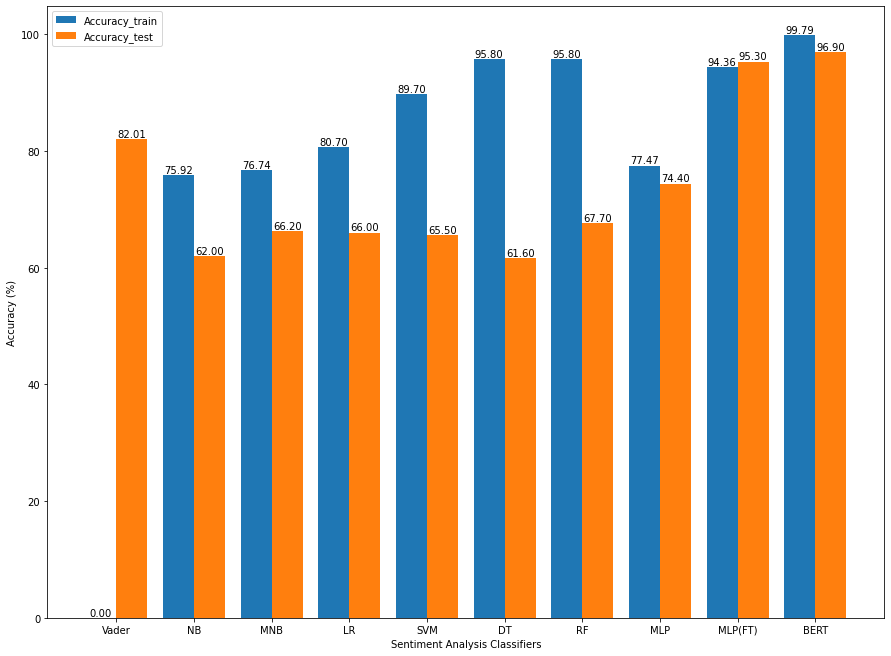

In [135]:
size = 10
# 返回size个0-1的随机数
accuracy_train = [0,75.925,76.7375,80.7,89.7,95.8,95.8,77.475,94.3625,99.788]
accuracy_test = [82.012,62.0,66.2,66.0,65.5,61.6,67.7,74.4,95.3,96.897]
#F1 = np.random.random(size)
# x轴坐标, size=5, 返回[0, 1, 2, 3, 4]
x = np.arange(size)

# 有a/b/c三种类型的数据，n设置为3
total_width, n = 0.8, 2
# 每种类型的柱状图宽度
width = total_width / n

# 重新设置x轴的坐标
x = x - (total_width - width) / 2
print(x)
scale = 15
ratio = 0.75
plt.figure(figsize=(scale, scale*ratio))
# 画柱状图
plt.bar(x - width/2, accuracy_train, width=width, label="Accuracy_train")
plt.bar(x + width/2, accuracy_test, width=width, label="Accuracy_test")
#plt.bar(x + 2*width, c, width=width, label="c")

# 功能1
x_label = ["Naive Bayes", "Multinomial Naive Bayes", "Logistic Regression", "Support Vector Machine", "Decision Tree","Random Forest"]
x_labels = ["Vader","NB", "MNB", "LR", "SVM", "DT","RF","MLP","MLP(FT)","BERT"]
# 用第1组...替换横坐标x的值
plt.xticks(x, x_labels)

# 功能2
fsize = 10
for i, j in zip(x - width/2, accuracy_train):
    plt.text(i, j + 0.01, "%.2f" % j, ha="center", va="bottom", fontsize=fsize)
for i, j in zip(x + width/2, accuracy_test):
    plt.text(i, j + 0.01, "%.2f" % j, ha="center", va="bottom", fontsize=fsize)
#for i, j in zip(x + 2 * width, c):
#    plt.text(i, j + 0.01, "%.2f" % j, ha="center", va="bottom", fontsize=7)

# 设置x轴标签名
plt.xlabel("Sentiment Analysis Classifiers")
# 设置y轴标签名
plt.ylabel("Accuracy (%)")    
# 显示图例
plt.legend()
# 显示柱状图
plt.show()